In [ ]:
import pandas as pd
import seaborn as sns
from tsfresh import extract_features
from tsfresh.utilities.dataframe_functions import impute

# Load and prepare the dataset
flights = sns.load_dataset('flights')
month_map = {
    'Jan': '01', 'Feb': '02', 'Mar': '03', 'Apr': '04', 'May': '05', 'Jun': '06',
    'Jul': '07', 'Aug': '08', 'Sep': '09', 'Oct': '10', 'Nov': '11', 'Dec': '12'
}
flights['month_str'] = flights['month'].map(month_map).astype(str)
flights['year_str'] = flights['year'].astype(str)
flights['date'] = flights['year_str'] + '-' + flights['month_str'] + '-01'
flights['date'] = pd.to_datetime(flights['date'])
flights = flights[['date', 'passengers']]

# Add an ID column for tsfresh (required)
flights['id'] = 1  # since this is one single time series

# Rename columns as needed by tsfresh
flights = flights.rename(columns={'date': 'time', 'passengers': 'value'})

fc_parameters = {
    "length": None,
    "large_standard_deviation": [{"r": 0.05}, {"r": 0.1}]
}

# Extract features
extracted_features = extract_features(
    flights,
    default_fc_parameters=fc_parameters,
    column_id='id',
    column_sort='time',
    column_value='value',
    disable_progressbar=False
)

# Impute missing values if needed (tsfresh requires this before using features)
impute(extracted_features)

print(extracted_features.T.sort_index())


In [ ]:
from tsfresh.utilities.dataframe_functions import roll_time_series
import pandas as pd

# Example time series data
# data = {'id': [1, 1, 1, 2, 2, 2],
#         'time': [1, 2, 3, 1, 2, 3],
#         'value': [10, 20, 30, 15, 25, 35]}
data = {'id': [1, 1, 1, 1, 1, 1],
        'time': [1, 2, 3, 4, 5, 6],
        'value': [10, 20, 30, 15, 25, 35]}
df = pd.DataFrame(data)

# Roll the time series with a window size of 2
rolled_df = roll_time_series(df, column_id="id", column_sort="time", max_timeshift=1)

print(rolled_df)

# Windowed

In [18]:
import pandas as pd
import seaborn as sns
from tsfresh import extract_features
from tsfresh.utilities.dataframe_functions import impute, roll_time_series
import numpy as np

# --- Original Data Loading and Preparation ---
flights = sns.load_dataset('flights')
month_map = {
    'Jan': '01', 'Feb': '02', 'Mar': '03', 'Apr': '04', 'May': '05', 'Jun': '06',
    'Jul': '07', 'Aug': '08', 'Sep': '09', 'Oct': '10', 'Nov': '11', 'Dec': '12'
}
flights['month_str'] = flights['month'].map(month_map).astype(str)
flights['year_str'] = flights['year'].astype(str)
flights['date'] = flights['year_str'] + '-' + flights['month_str'] + '-01'
flights['date'] = pd.to_datetime(flights['date'])

# Prepare DataFrame for tsfresh and rolling - ensure only id, time, value are present
flights_prepared = flights[['date', 'passengers']].copy()

flights_prepared['id'] = 1 # Original ID for the single time series
# Rename columns as needed by tsfresh for the *rolling process*
flights_prepared = flights_prepared.rename(columns={'date': 'time', 'passengers': 'value'})

# Add a lagged column (t-1), which excludes the current time point (t)
flights_prepared['value_lag1'] = flights_prepared['value'].shift(1)

# --- Rolling Window Configuration ---
# In this version of tsfresh, max_timeshift defines the window length
window_length = 12 # Using window_length for clarity that it maps to max_timeshift


# --- Create Windowed Data using roll_time_series ---
print(f"Creating rolling windows with length {window_length} using roll_time_series...")
# Use max_timeshift parameter as per the function signature
rolled_flights_df = roll_time_series(
    flights_prepared,
    column_id='id',        # The original ID column
    column_sort='time',    # Use column_sort for the time column
    # column_value is NOT needed here, it's inferred or not accepted
    max_timeshift=window_length, # Corrected: Use max_timeshift for window length
    # min_timeshift=window_length - 1,
    # rolling_direction=1 (default) means rolling forward
    # min_timeshift=0 (default) means including windows of size 1 up to max_timeshift
    # If you only want windows of exactly size 'window_length', you might need
    # min_timeshift=window_length - 1, but let's try with default min_timeshift first.
)

print("Rolling windows created. Example structure (first 5 rows of the windowed data):")
print(rolled_flights_df.head())
print("\nExample structure (last 5 rows of the windowed data):")
print(rolled_flights_df.tail())


# --- Define Features to Extract ---
fc_parameters = {
    "length": None, # When using roll_time_series, length feature might refer to the window length
    # "large_standard_deviation": [{"r": 0.05}, {"r": 0.1}],
    "mean": None,
    "median": None,
    "standard_deviation": None,
    "variance": None,
    "maximum": None,
    "minimum": None,
    "abs_energy": None
}

# --- Extract Features on the Rolled Data ---
# extract_features *DOES* require column_value
print("\nExtracting features from windows...")
extracted_features_windows = extract_features(
    rolled_flights_df,
    default_fc_parameters=fc_parameters,
    column_id='id',        # Use the new window IDs created by roll_time_series
    column_sort='time',    # Time column within each window
    column_value='value',  # Specify the value column for feature calculation
    disable_progressbar=False
)

# --- Impute missing values ---
impute(extracted_features_windows)

extracted_features_windows = extracted_features_windows.reset_index(names=["id", "time"])
feature_store = pd.merge(flights_prepared, extracted_features_windows, how="left", on=["time", "id"])


# The index of extracted_features_windows will be the window IDs
# Each row represents the features extracted from one window.
print("\nFeatures extracted from rolling windows:")
print(extracted_features_windows.head())

print(f"\nNumber of windows processed: {len(extracted_features_windows)}")

c:\Users\douglas.sgrott_indic\miniconda3\envs\tsfresh_venv\lib\site-packages\tsfresh\utilities\dataframe_functions.py:520: UserWarning: Your time stamps are not uniformly sampled, which makes rolling nonsensical in some domains.
  warnings.warn(


Creating rolling windows with length 12 using roll_time_series...


Rolling: 100%|██████████| 36/36 [00:07<00:00,  4.81it/s]


Rolling windows created. Example structure (first 5 rows of the windowed data):
        time  value                        id  value_lag1
0 1949-01-01    112  (1, 1949-01-01 00:00:00)         NaN
1 1949-01-01    112  (1, 1949-02-01 00:00:00)         NaN
2 1949-02-01    118  (1, 1949-02-01 00:00:00)       112.0
3 1949-01-01    112  (1, 1949-03-01 00:00:00)         NaN
4 1949-02-01    118  (1, 1949-03-01 00:00:00)       112.0

Example structure (last 5 rows of the windowed data):
           time  value                        id  value_lag1
1789 1960-08-01    606  (1, 1960-12-01 00:00:00)       622.0
1790 1960-09-01    508  (1, 1960-12-01 00:00:00)       606.0
1791 1960-10-01    461  (1, 1960-12-01 00:00:00)       508.0
1792 1960-11-01    390  (1, 1960-12-01 00:00:00)       461.0
1793 1960-12-01    432  (1, 1960-12-01 00:00:00)       390.0

Extracting features from windows...


Feature Extraction: 100%|██████████| 36/36 [00:07<00:00,  4.92it/s]


Features extracted from rolling windows:
   id       time  value__length  value__mean  value__median  \
0   1 1949-01-01            1.0   112.000000          112.0   
1   1 1949-02-01            2.0   115.000000          115.0   
2   1 1949-03-01            3.0   120.666667          118.0   
3   1 1949-04-01            4.0   122.750000          123.5   
4   1 1949-05-01            5.0   122.400000          121.0   

   value__standard_deviation  value__variance  value__maximum  value__minimum  \
0                   0.000000         0.000000           112.0           112.0   
1                   3.000000         9.000000           118.0           112.0   
2                   8.379870        70.222222           132.0           112.0   
3                   8.104783        65.687500           132.0           112.0   
4                   7.282857        53.040000           132.0           112.0   

   value__abs_energy  
0            12544.0  
1            26468.0  
2            43892.0  


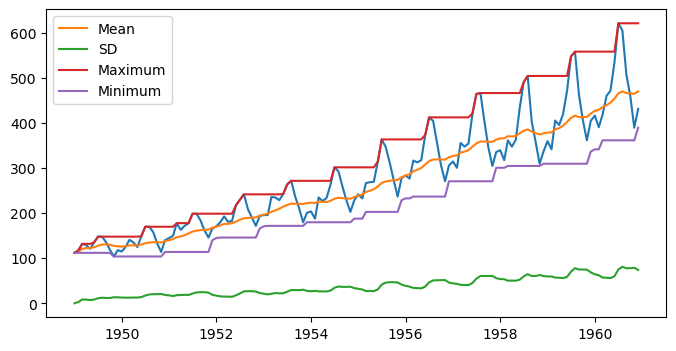

In [10]:
foo = extracted_features_windows.reset_index(names=["id", "time"])
# rolled_flights_df

import matplotlib.pyplot as plt

fig, axes = plt.subplots(figsize=(8,4))

axes.plot(flights_prepared['time'], flights_prepared['value'])
axes.plot(foo['time'], foo['value__mean'], label="Mean")
axes.plot(foo['time'], foo['value__standard_deviation'], label="SD")
# axes.plot(foo['time'], foo['value__variance'], label="Variance")
axes.plot(foo['time'], foo['value__maximum'], label="Maximum")
axes.plot(foo['time'], foo['value__minimum'], label="Minimum")
# axes.plot(foo['time'], foo['value__abs_energy'], label="Abs. Energy")

plt.legend()

In [ ]:


display(foo.head(2))
display(flights_prepared.head(2))

# bar = foo.copy()
# bar.set_index('time', inplace=True)
# baz = flights_prepared.copy()
# baz.set_index('time', inplace=True)

# display(bar.head(2))
# display(baz.head(2))

,id,time,value__length,value__mean,value__median,value__standard_deviation,value__variance,value__maximum,value__minimum,value__abs_energy
0,1,1949-01-01,1.0,112.0,112.0,0.0,0.0,112.0,112.0,12544.0
1,1,1949-02-01,2.0,115.0,115.0,3.0,9.0,118.0,112.0,26468.0


,time,value,id,value_lag1
0,1949-01-01,112,1,NaN
1,1949-02-01,118,1,112.0


,time,value,id,value_lag1
0,1949-01-01,112,1,NaN
1,1949-02-01,118,1,112.0
2,1949-03-01,132,1,118.0


In [ ]:
# bar.join(baz, on='index')


,time,value,id,value_lag1,value__length,value__mean,value__median,value__standard_deviation,value__variance,value__maximum,value__minimum,value__abs_energy
0,1949-01-01,112,1,NaN,1.0,112.000000,112.0,0.000000,0.000000,112.0,112.0,12544.0
1,1949-02-01,118,1,112.0,2.0,115.000000,115.0,3.000000,9.000000,118.0,112.0,26468.0
2,1949-03-01,132,1,118.0,3.0,120.666667,118.0,8.379870,70.222222,132.0,112.0,43892.0
3,1949-04-01,129,1,132.0,4.0,122.750000,123.5,8.104783,65.687500,132.0,112.0,60533.0
4,1949-05-01,121,1,129.0,5.0,122.400000,121.0,7.282857,53.040000,132.0,112.0,75174.0
...,...,...,...,...,...,...,...,...,...,...,...,...
139,1960-08-01,606,1,622.0,13.0,470.692308,461.0,81.042614,6567.905325,622.0,362.0,2965549.0
140,1960-09-01,508,1,606.0,13.0,466.769231,461.0,77.844178,6059.715976,622.0,362.0,2911132.0
141,1960-10-01,461,1,508.0,13.0,466.615385,461.0,77.853451,6061.159763,622.0,362.0,2909284.0
142,1960-11-01,390,1,461.0,13.0,465.307692,461.0,78.978463,6237.597633,622.0,362.0,2895735.0


In [ ]:
print(flights_prepared.shape) # (144, 3)
print(extracted_features_windows.shape) # (133, 2)
display(flights_prepared.head(15))
display(extracted_features_windows[['value__length', 'value__mean', ]].head(15))


In [ ]:
print(extracted_features_windows.shape)
print(flights_prepared.shape)
print()

for i in range(0, flights_prepared.shape[0]):
    start = max(0, i - 1 - 12)
    end = i + 1
    # print(start, end)
    date_str = str(flights_prepared.iloc[i]['time']).split()[0]
    print(f"({i};{start}:{end}) - {date_str}: mean of flights = {flights_prepared.iloc[start:end]['value'].mean():.2f}, value__mean (rolled): {extracted_features_windows.iloc[i]['value__mean']:.2f}")


# Features

In [ ]:
value__variance_larger_than_standard_deviation
value__has_duplicate_<max;min>
value__has_duplicate
value__sum_values
value__abs_energy
value__mean_<abs_change;change;second_derivative_central>
value__median
value__mean
value__length
value__standard_deviation
value__variation_coefficient
value__variance
value__skewness
value__kurtosis
value__root_mean_square
value__absolute_sum_of_changes
value__longest_strike_below_mean
value__longest_strike_above_mean
value__count_<above;below>_mean
value__<last;first>_location_of_maximum
value__<last;first>_location_of_minimum
value__percentage_of_reoccurring_values_to_all_values
value__percentage_of_reoccurring_datapoints_to_all_datapoints
value__sum_of_reoccurring_<values;data_points>
value__ratio_value_number_to_time_series_length
value__sample_entropy
value__maximum
value__absolute_maximum
value__minimum
value__benford_correlation
value__time_reversal_asymmetry_statistic__lag_<1;2;3>
value__c3__lag_<1;2;3>
value__cid_ce__normalize_<True;False>

value__symmetry_looking__r_<0.0;0.05;0.1;0.15;0.2;0.25;0.30;0.35;0.4;0.45;0.5;0.55;0.60;0.65;0.70;0.75;0.8;0.85;0.9;0.95>
value__large_standard_deviation__r_<0.05;0.1;0.15;0.2;0.25;0.30;0.35;0.4;0.45;0.5;0.55;0.60;0.65;0.70;0.75;0.8;0.85;0.9;0.95>
value__quantile__q_<0.1;0.2;0.3;0.4;0.6;0.7;0.8;0.9>
value__autocorrelation__lag_<0;1;2;3;4;5;6;7;8;9>
value__agg_autocorrelation__f_agg_<"mean";"median";"var">__maxlag_40
value__partial_autocorrelation__lag_<0;1;2;3;4;5;6;7;8;9>
value__number_cwt_peaks__n_<1;5>
value__number_peaks__n_<1;3;5;10;50>
value__binned_entropy__max_bins_10
value__index_mass_quantile__q_<0.1;0.2;0.3;0.4;0.6;0.7;0.8;0.9>
value__cwt_coefficients__coeff_<0to14>__w_<2;5;10;20>__widths_(2, 5, 10, 20)
value__spkt_welch_density__coeff_<2;5;8>
value__ar_coefficient__coeff_<0;1;2;3;4;5;6;7;8;9;10>__k_10
value__change_quantiles__f_agg_<"mean";"var">__isabs_<False;True>__qh_<0.2;0.4;0.6;0.8;1.0>__ql_<0.0;0.2;0.4;0.6;0.8>
value__fft_coefficient__attr_<"real";"imag";"abs";"angle">__coeff_<0to99>
value__fft_aggregated__aggtype_<"centroid";"variance";"skew";"kurtosis">
value__value_count__value_<0;1;-1>
value__range_count__max_1__min_-1
value__range_count__max_0__min_-1000000000000.0
value__range_count__max_1000000000000.0__min_0
value__approximate_entropy__m_2__r_<0.1;0.3;0.5;0.7;0.9>
value__friedrich_coefficients__coeff_<0;1;2;3>__m_3__r_30
value__max_langevin_fixed_point__m_3__r_30
value__linear_trend__attr_<"pvalue";"rvalue";"intercept";"slope";"stderr">
value__agg_linear_trend__attr_<"rvalue";"intercept";"slope";"stderr">__chunk_len_<5;10;50>__f_agg_<"max";"min";"mean";"var">
value__augmented_dickey_fuller__attr_<"teststat";"pvalue";"usedlag">__autolag_"AIC"
value__number_crossing_m__m_<0;-1;1>
value__energy_ratio_by_chunks__num_segments_10__segment_focus_<0to9>
value__ratio_beyond_r_sigma__r_<0.5;1;1.5;2;2.5;3;5;6;7;10>
value__count_<above;below>__t_0
value__lempel_ziv_complexity__bins_<2;3;5;10;100>
value__fourier_entropy__bins_<2;3;5;10;100>
value__permutation_entropy__dimension_<3;4;5;6;7>__tau_1
value__query_similarity_count__query_None__threshold_0.0
value__matrix_profile__feature_<"min";"max";"mean";"median";"25";"75">__threshold_0.98;
value__mean_n_absolute_max__number_of_maxima_7
